In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setup

Plotting

In [23]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


## Load data

In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = '_Mmin10'
geo_tag = '_bins10'
scalar_tag = '_n3'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1_Mmin10.yaml
../configs/scalar_TNG100-1_Mmin10_bins10_n3.yaml


In [4]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [5]:
x_scalars, x_scalars_extra = utils.load_features('scalars', sim_reader, fn_scalar_config=fn_scalar_config)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
loading scalar features
loaded


In [6]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [7]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [8]:
np.min(log_m_200m+log_mass_shift), np.max(log_m_200m+log_mass_shift)

(10.120551, 14.563137)

In [9]:
len(log_m_200m)

32146

Text(0, 0.5, 'number per bin')

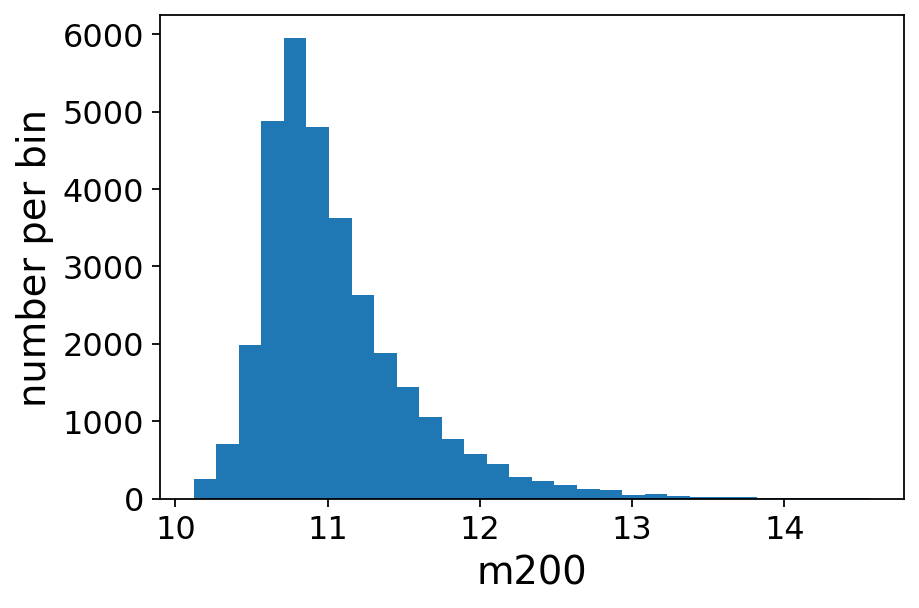

In [10]:
plt.hist(log_m_200m+log_mass_shift, bins=30)
plt.xlabel('m200')
plt.ylabel('number per bin')

# M stellar

In [11]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
#fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
fit_tag = f'_{y_label_name}_hgboost_scalars_epochs300_lr0.1_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.npy'

In [12]:
y_pred = np.load(fn_pred)

In [13]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

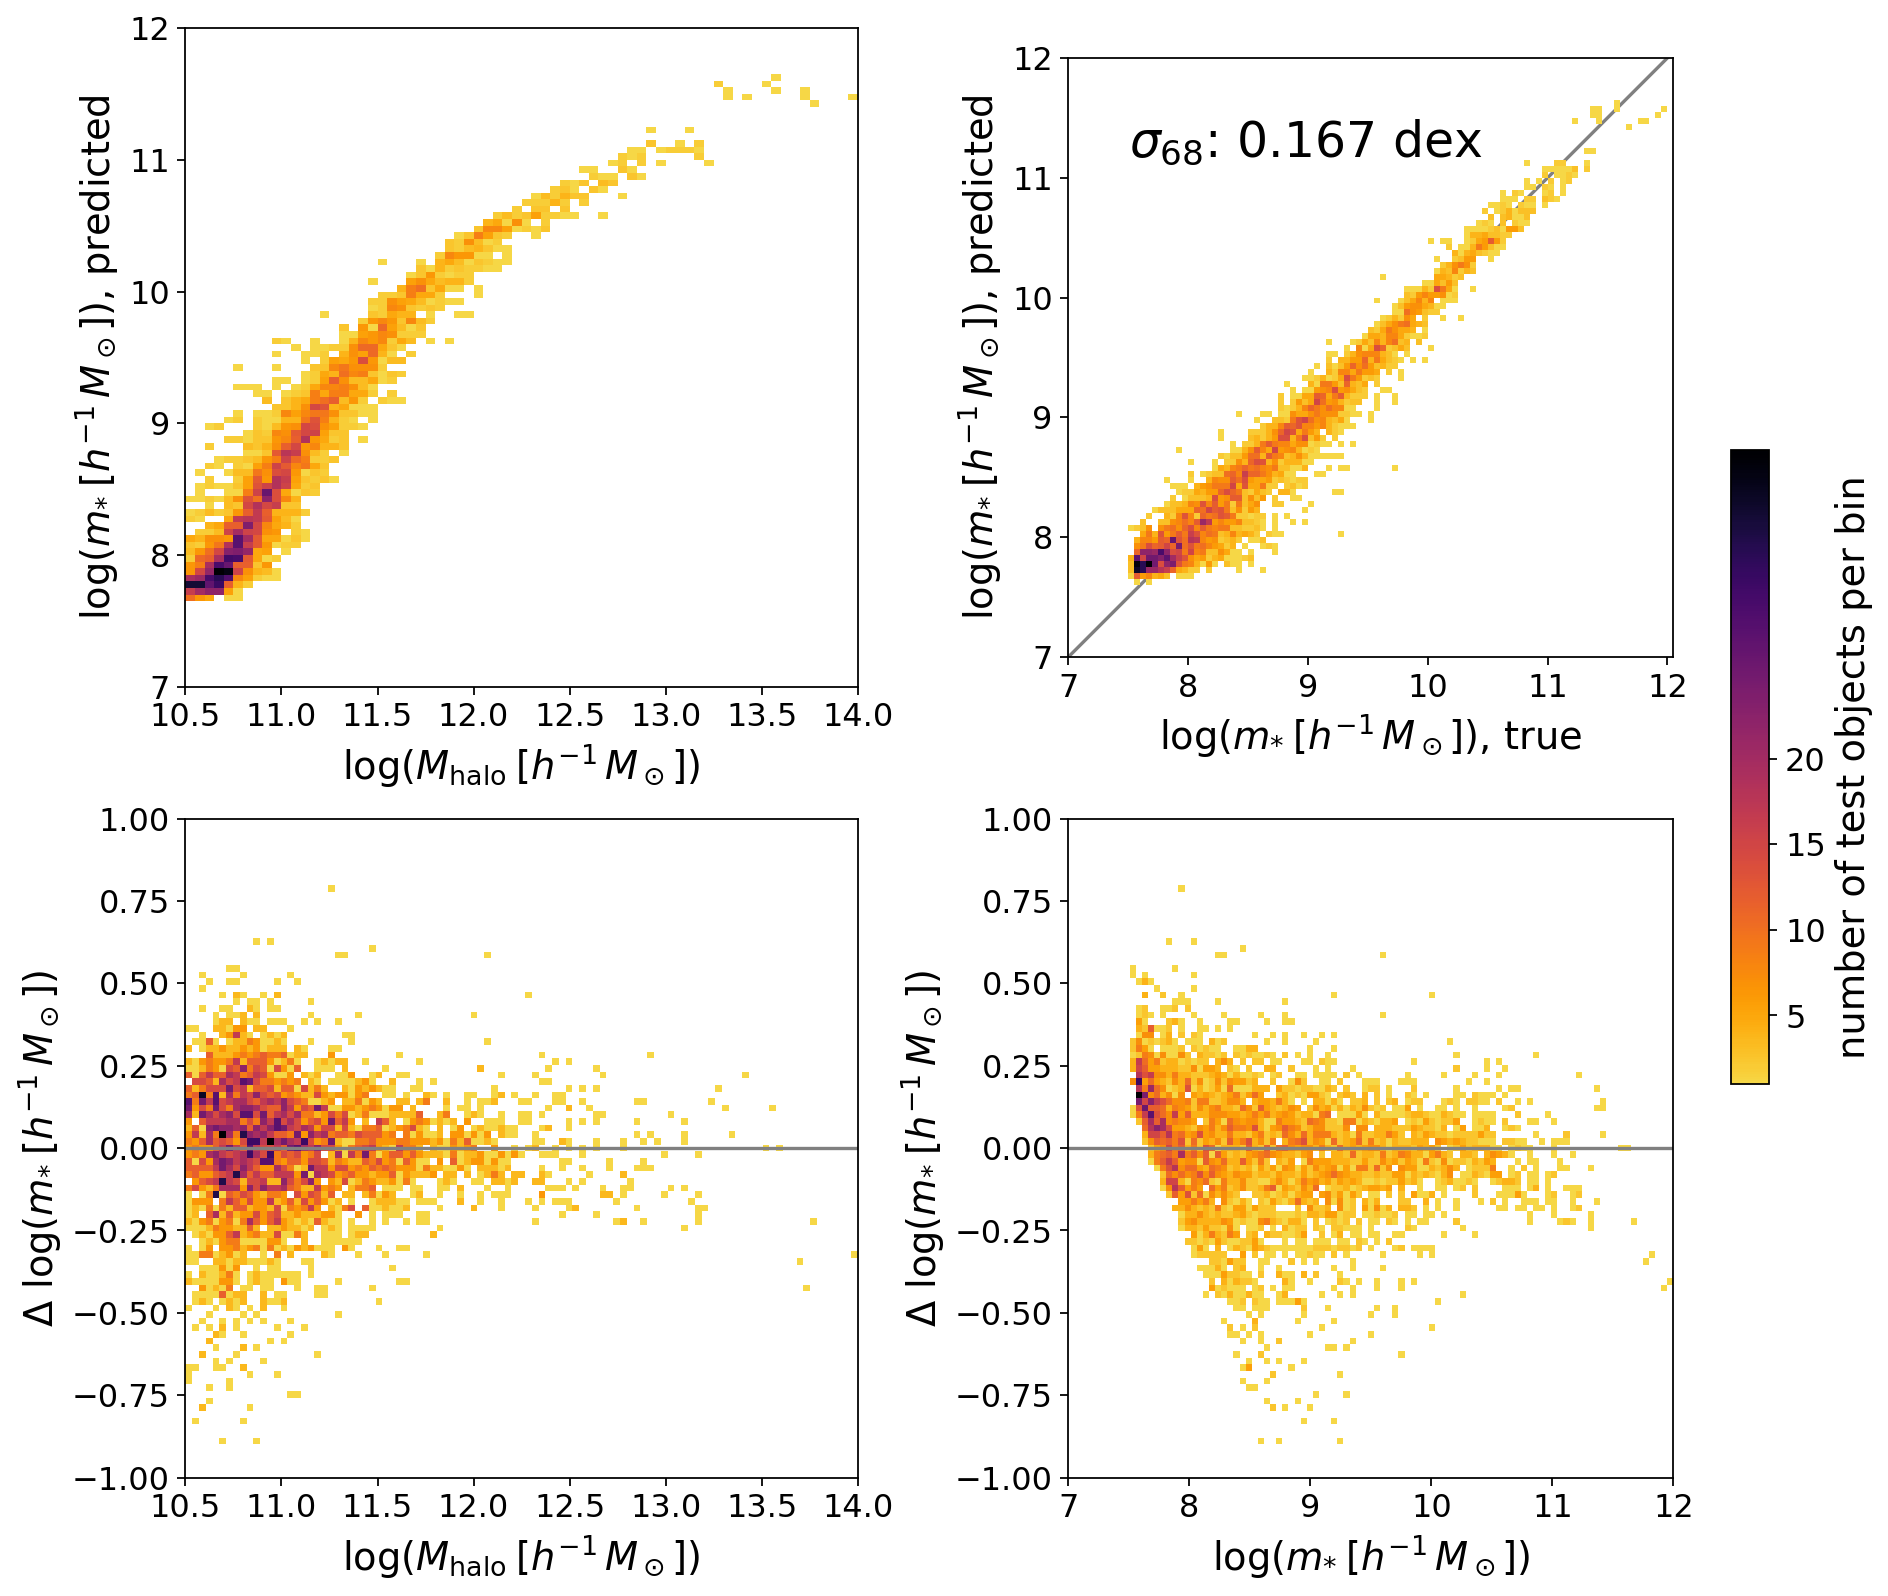

In [14]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)

# Feature plots for Mstellar

In [15]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']

In [16]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', 'M200, R200, V200']


In [26]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):
    #fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    fit_tag = f'_{y_label_name}_hgboost_{feature_mode}_epochs300_lr0.1_hs128'
    if feature_mode=='geos':
        fit_tag = '_bins10'+fit_tag
    if feature_mode=='scalars':
        fit_tag = '_bins10_n3'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_mult = y_pred + log_mass_shift
    y_pred_arr.append(y_pred_mult)
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

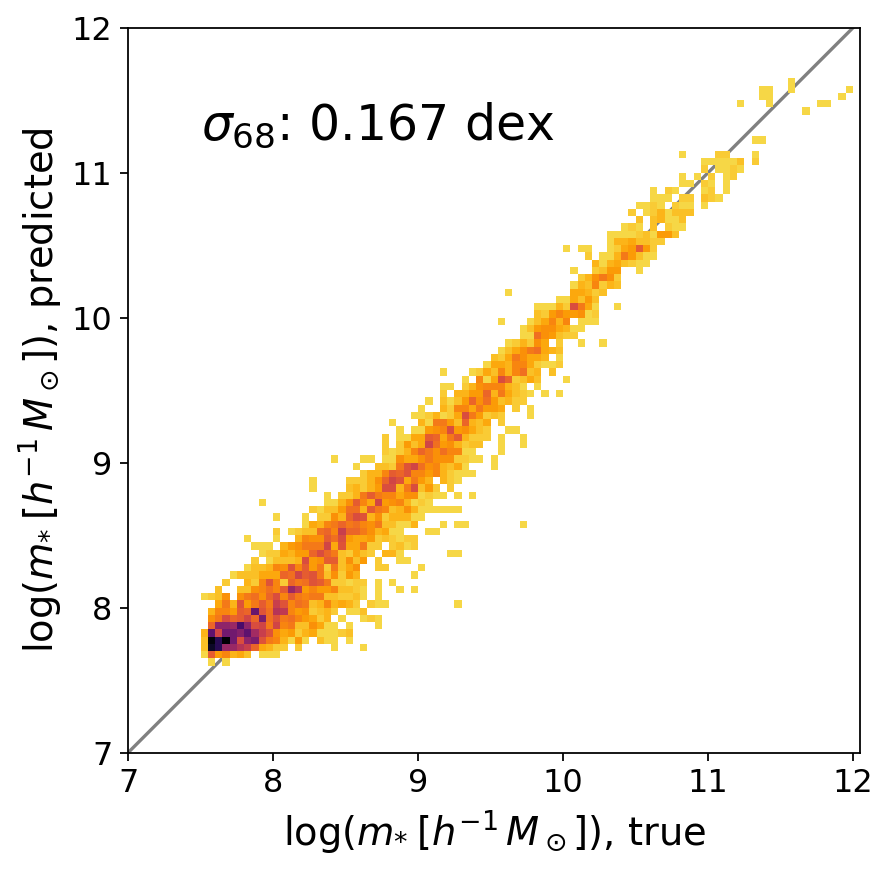

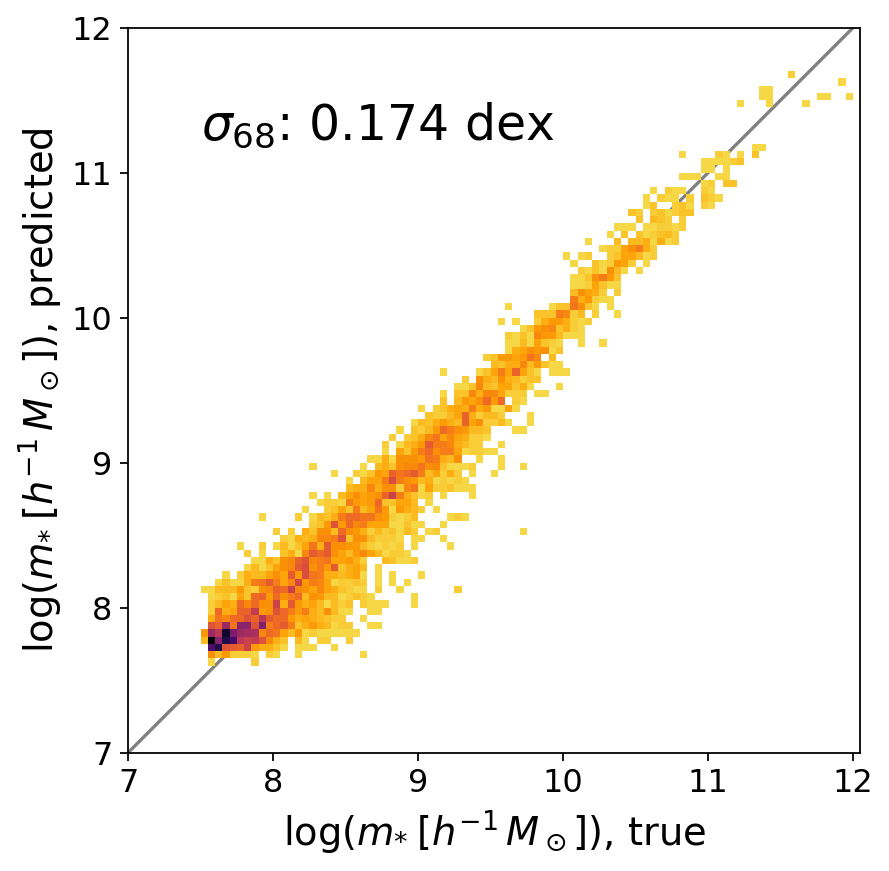

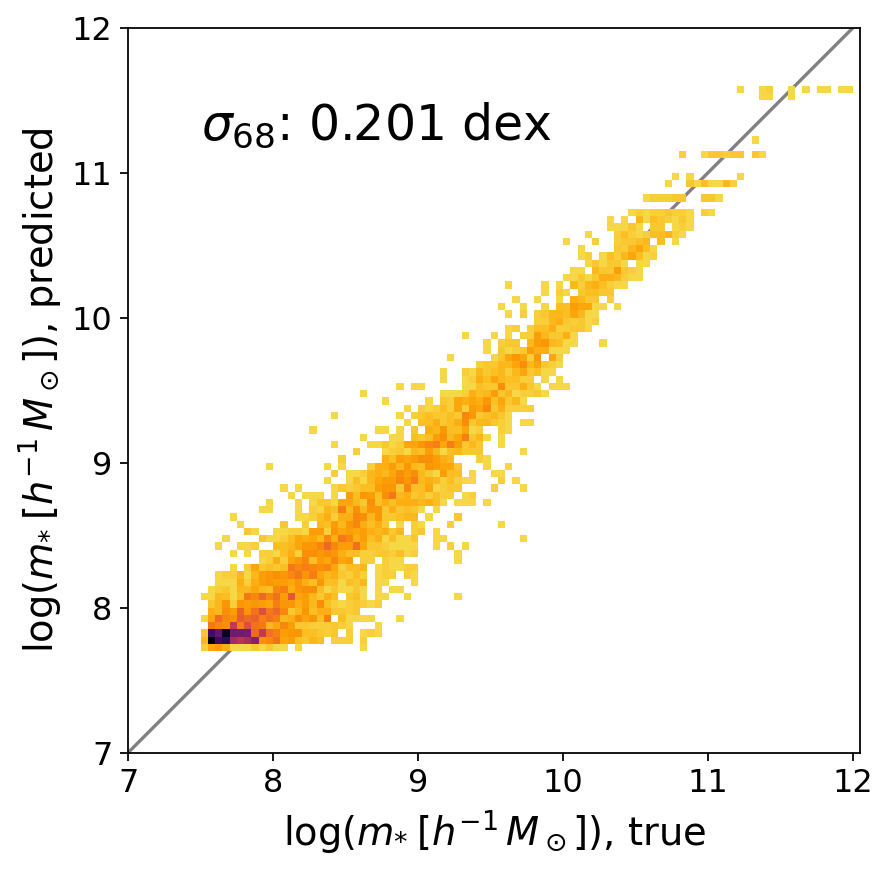

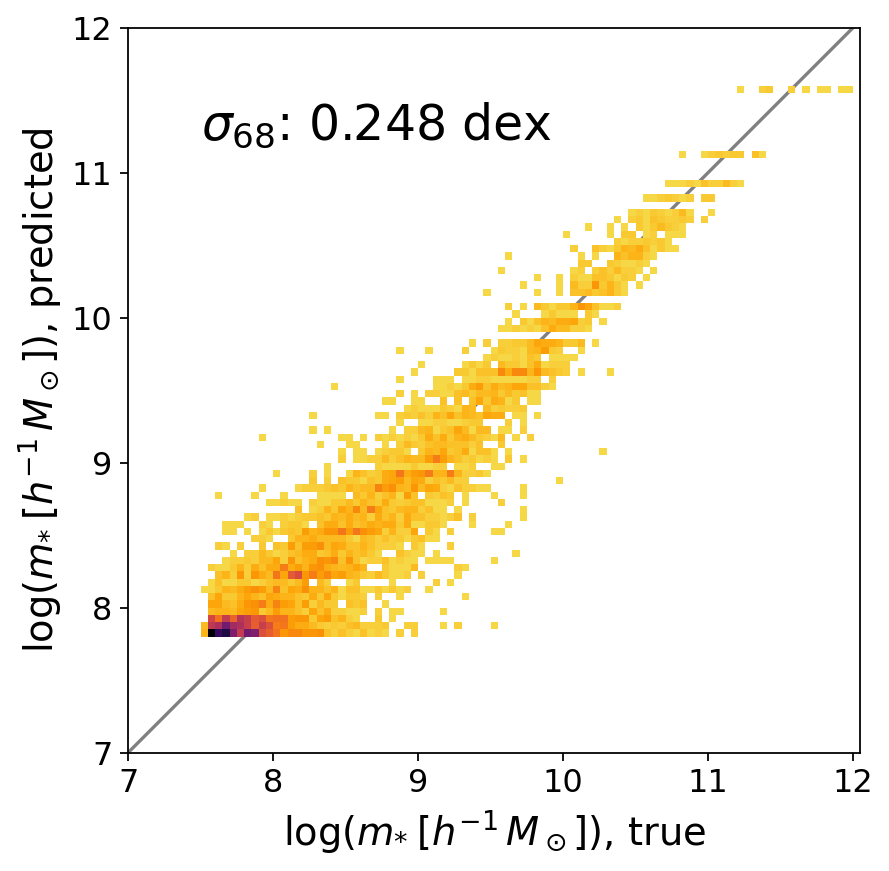

In [27]:
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap_hist, text_results=text_results_arr[i])